In [1]:
from os import path as op
import nibabel as nb
import numpy as np
from scipy.stats import zscore

In [2]:
sub_id = '51205'
func_nii = nb.load(op.abspath('./data/sub-{}_task-rest_bold_mcf.nii.gz'.format(sub_id)))
mask_nii = nb.load(op.abspath('./data/sub-{}_task-rest_bold_mcf_mask.nii.gz'.format(sub_id)))
func_data = func_nii.get_data()
mask_data = mask_nii.get_data()
func_shape = func_data.shape
ntsteps = func_shape[-1]

In [14]:
def auto_mask(data, raw_d=None, nskip=3, mask_bad_end_vols=False):
    from dipy.segment.mask import median_otsu
    mn = data[:, :, :, nskip:].mean(3)
    masked_data, mask = median_otsu(mn, 3, 2)
    mask = np.concatenate((
        np.tile(True, (data.shape[0], data.shape[1], data.shape[2], nskip)),
        np.tile(np.expand_dims(mask == 0, 3), (1, 1, 1, data.shape[3]-nskip))),
        axis=3)
    mask_vols = np.zeros((mask.shape[-1]), dtype=int)
    if mask_bad_end_vols:
        # Some runs have corrupt volumes at the end (e.g., mux scans that are stopped prematurely). Mask those too.
        # But... motion correction might have interpolated the empty slices such that they aren't exactly zero.
        # So use the raw data to find these bad volumes.
        # 2015.10.29 RFD: this caused problems with some non-mux EPI scans that (inexplicably)
        # have empty slices at the top of the brain. So we'll disable it for
        # now.
        if raw_d is None:
            slice_max = data.max(0).max(0)
        else:
            slice_max = raw_d.max(0).max(0)

        bad = np.any(slice_max == 0, axis=0)
        # We don't want to miss a bad volume somewhere in the middle, as that could be a valid artifact.
        # So, only mask bad vols that are contiguous to the end.
        mask_vols = np.array([np.all(bad[i:]) for i in range(bad.shape[0])])
    # Mask out the skip volumes at the beginning
    mask_vols[0:nskip] = True
    mask[:, :, :, mask_vols] = True
    brain = np.ma.masked_array(data, mask=mask)
    good_vols = np.logical_not(mask_vols)
    return brain, good_vols


def find_spikes(data, spike_thresh):
    slice_mean = data.mean(axis=0).mean(axis=0)
    t_z = (slice_mean - np.atleast_2d(slice_mean.mean(axis=1)).T) / np.atleast_2d(
        slice_mean.std(axis=1)).T
    spikes = np.abs(t_z) > spike_thresh
    spike_inds = np.transpose(spikes.nonzero())
    # mask out the spikes and recompute z-scores using variance uncontaminated with spikes.
    # This will catch smaller spikes that may have been swamped by big ones.
    data.mask[:, :, spike_inds[:, 0], spike_inds[:, 1]] = True
    slice_mean2 = data.mean(axis=0).mean(axis=0)
    t_z = (slice_mean - np.atleast_2d(slice_mean.mean(axis=1)).T) / np.atleast_2d(
        slice_mean2.std(axis=1)).T
    spikes = np.logical_or(spikes, np.abs(t_z) > spike_thresh)
    spike_inds = np.transpose(spikes.nonzero())
    return spike_inds, t_z

In [15]:
%matplotlib inline

tr = 0.8

def plot_spikes(ts_z, tr=None, spike_thresh=6., title='Spike plot'):
    import matplotlib.pyplot as plt
    from matplotlib.cm import get_cmap
    from matplotlib.colors import Normalize
    from matplotlib.colorbar import ColorbarBase
    my_cmap = get_cmap('viridis')
    nsl = ts_z.shape[0]-1
    ntsteps = ts_z.shape[-1]
    norm = Normalize(vmin=0, vmax=float(nsl))
    colors = [my_cmap(norm(sl)) for sl in range(ts_z.shape[0])]

    sl_num = np.tile(range(ts_z.shape[0]), (ts_z.shape[1], 1)).T
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(111)
    for sl in range(ts_z.shape[0]):
        ax.plot(ts_z[sl,...].data, color=colors[sl], lw=3)

    ax.set_ylabel('Slice\'s z-score')
    ax.axis('tight')
    ax.grid(False)

    ax.set_ylim((-(np.abs(ts_z).max()) * 1.05, (np.abs(ts_z).max()) * 1.05))
    ax.set_xlim(0, ntsteps - 1)
    xticks = list(range(0, ntsteps)[::20]) + [ntsteps-1]
    ax.set_xticks(xticks)

    if tr is None:
        ax.set_xlabel('time (frame #)')
    else:
        ax.set_xlabel('time (s)')
        ax.set_xticklabels(['%.02f' % t for t in (tr * np.array(xticks)).tolist()])

    zs_max = np.abs(ts_z).max()
    ytick_vals = np.arange(0.0, zs_max, 2.0)
    yticks = list(reversed((-1.0 * ytick_vals[ytick_vals > 0]).tolist())) + ytick_vals.tolist()
    yticks.insert(0, ts_z.min())
    yticks += [ts_z.max()]
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%.02f' % y for y in yticks])

    ax.plot((0,ntsteps), (yticks[0],yticks[0]),'k:')
    ax.plot((0,ntsteps), (yticks[-1],yticks[-1]),'k:')

    for val in ytick_vals:
        ax.plot((0,ntsteps),(-val,-val),'k:', alpha=.2)
        ax.plot((0,ntsteps),(val,val),'k:', alpha=.2)

    if zs_max < spike_thresh:
        ax.plot((0,ts_z.shape[1]),(-spike_thresh,-spike_thresh),'k:')
        ax.plot((0,ts_z.shape[1]),(spike_thresh,spike_thresh),'k:')

    cax = fig.add_axes([0.70, 0.90, 0.25, 0.01])
    cb = ColorbarBase(cax, cmap=my_cmap, norm=norm, spacing='proportional', orientation='horizontal', drawedges=False)
    cb.set_ticks([0, 0.5*nsl, nsl])
    cb.set_ticklabels(['Inferior', '(z-slice)', 'Superior'])
    cb.outline.set_linewidth(0)
    cb.ax.xaxis.set_tick_params(width=0)
    plt.tight_layout()

    for side in ["top", "right"]:
        # Toggle the spine objects
        ax.spines[side].set_color('none')
        ax.spines[side].set_visible(False)

    ax.spines["bottom"].set_position(('outward', 20))
    ax.spines["left"].set_position(('outward', 20))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    labels = [label for label in ax.yaxis.get_ticklabels()]
    labels[0].set_weight('bold')
    labels[-1].set_weight('bold')
    
    ax.set_title(title)
    return fig


In [16]:
spike_thresh = 6
brain = np.ma.array(func_data, mask=np.stack([mask_data!=1] * ntsteps, axis=-1))
background = np.ma.array(func_data, mask=np.stack([mask_data==1] * ntsteps, axis=-1))
global_ts = brain.mean(0).mean(0).mean(0)
global_bg = background.mean(0).mean(0).mean(0)
spikes, ts_z = find_spikes(brain - global_ts, spike_thresh)
spikes2, ts_z_bg = find_spikes(background - global_bg, spike_thresh)

brain3,good_vols = auto_mask(func_data, nskip=4)
global_ts3 = brain3.mean(0).mean(0).mean(0)
spikes3, ts_z3 = find_spikes(brain3 - global_ts, spike_thresh)

/home/oesteban/miniconda2/envs/nipypedev-3.5/lib/python3.5/site-packages/matplotlib-1.5.1-py3.5-linux-x86_64.egg/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


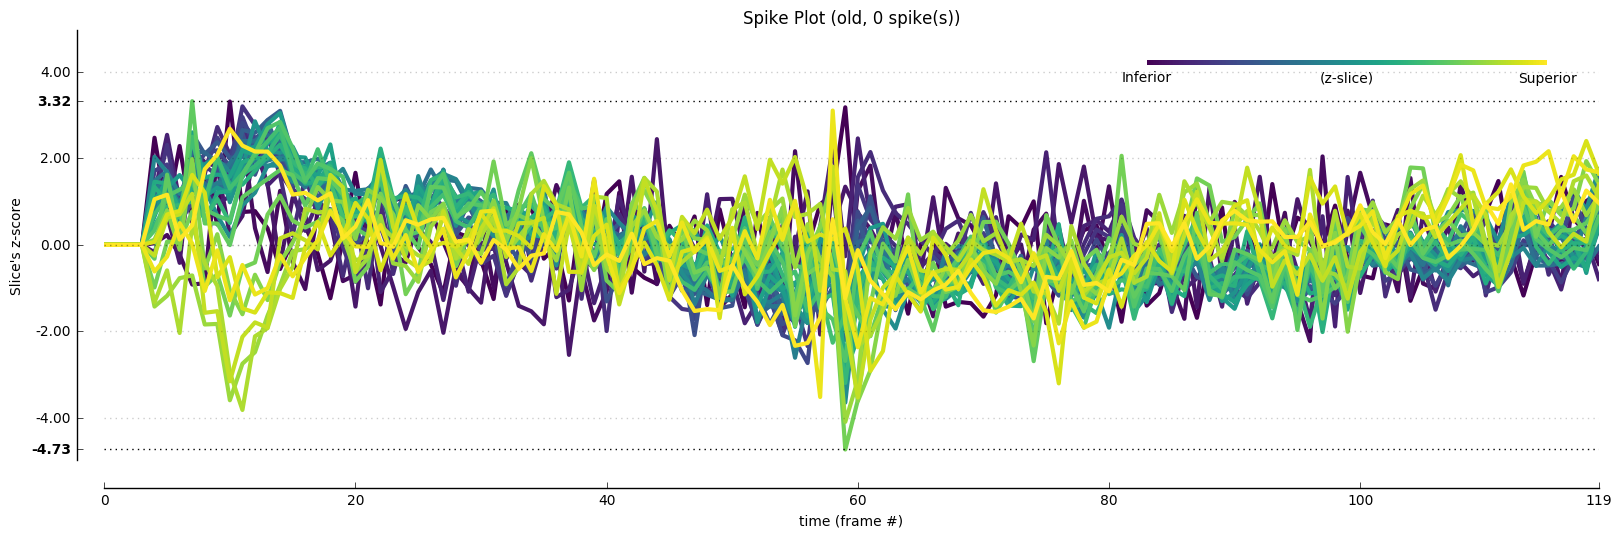

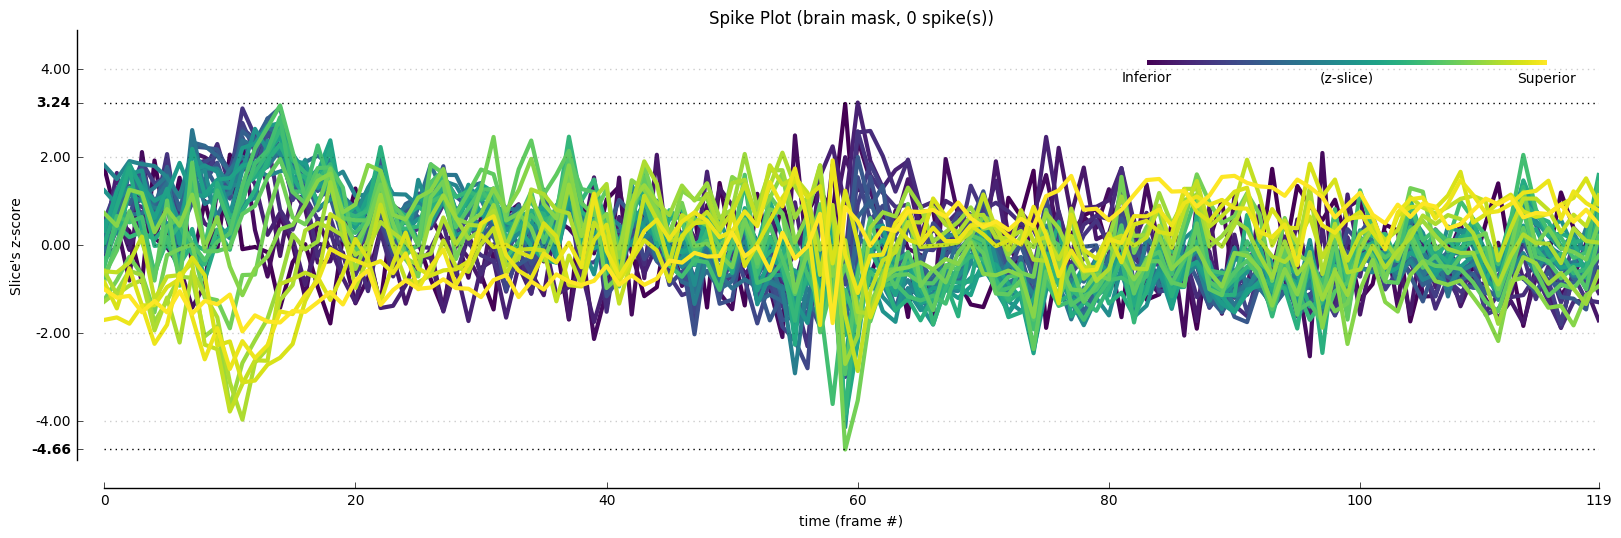

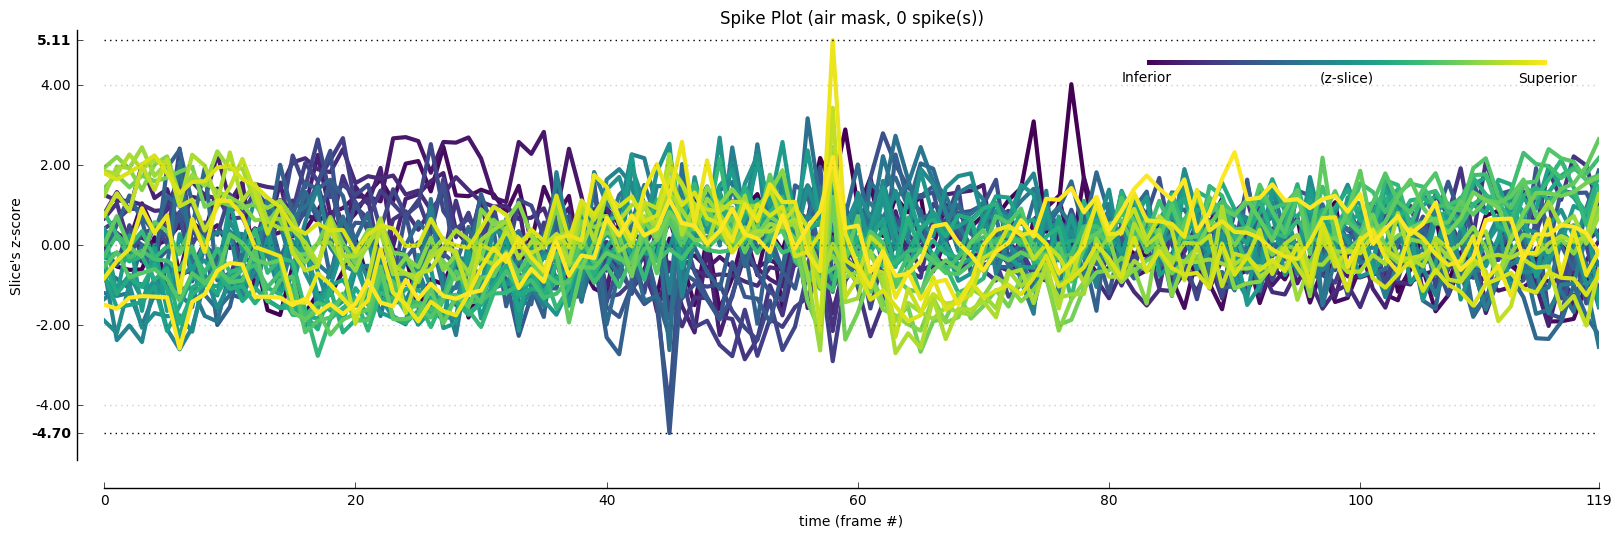

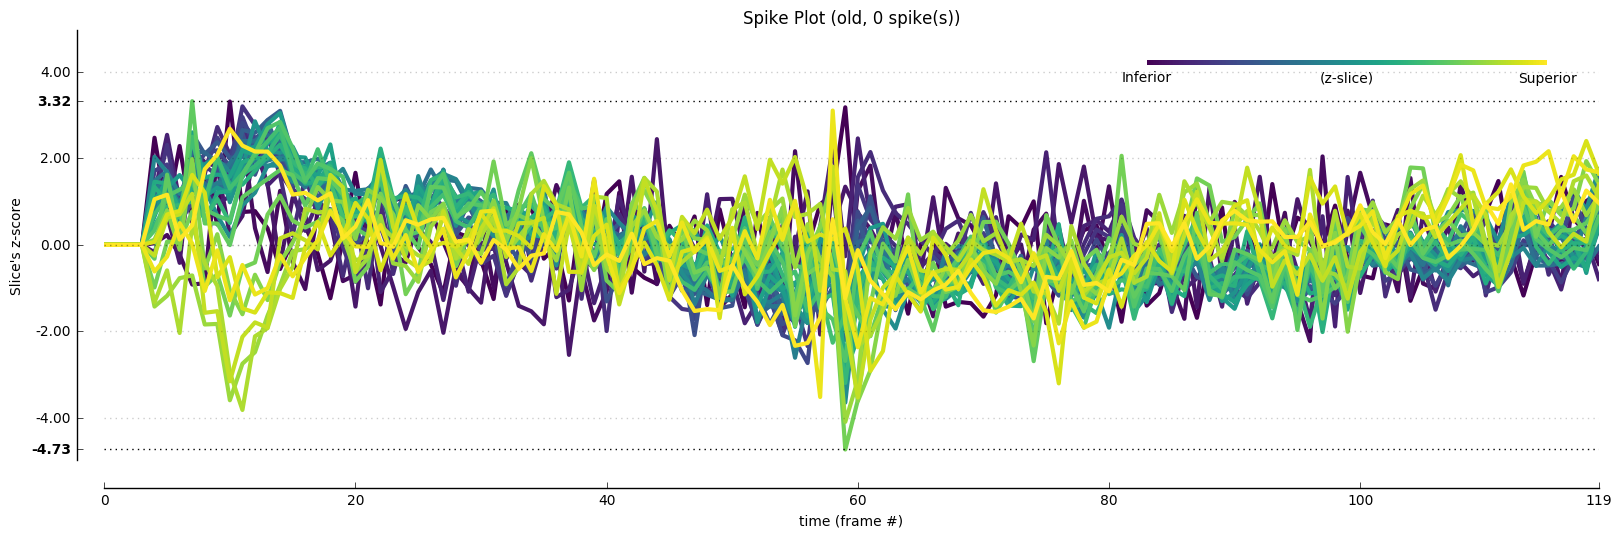

In [17]:
plot_spikes(ts_z, title='Spike Plot (brain mask, %d spike(s))' % spikes.shape[0])
plot_spikes(ts_z_bg, title='Spike Plot (air mask, %d spike(s))' % spikes2.shape[0])
plot_spikes(ts_z3, title='Spike Plot (old, %d spike(s))' % spikes3.shape[0])

In [ ]:
plt.clf()